In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection


file_path = "output/electrode_npp_results.npz"

data = np.load(file_path)
nodes = data['nodes']
elements = data['elements']
c1_history = data['c1_history']
c2_history = data['c2_history']
phi_history = data['phi_history']
dt = data['dt'].item()  # Use .item() to get scalar value
num_steps = c1_history.shape[0]
phi_c = data['phi_c'].item()
tau_c = data['tau_c'].item()


In [20]:
#constants = data['constants'].item()

In [21]:
physical_constants = {
        "R": 8.314,
        "T": 400,
        "F": 96485.33212,
        "epsilon": 80,
        "D1": 1e-9,
        "D2": 1e-9,
        "D3": 1e-9,
        "z1": 1,
        "z2": -1,
        "chi": 0,
        "c0": 1.0
    }

In [22]:
from utils.fem_mesh import TetrahedralMesh 

def calculate_electrode_current(electrode_node_idx, file_path="output/electrode_npp_3d_results.npz"):
    """
    Calculates the current flowing out of a single electrode by integrating the
    current density around a contour enclosing the electrode node.

    Args:
        electrode_node_idx (int): The node index of the electrode to analyze.
        file_path (str): Path to the saved simulation data (.npz file).
    """
    # 1. Load data
    data = np.load(file_path, allow_pickle=True)
    nodes = data['nodes']
    elements = data['elements']
    c1_history = data['c1_history']
    c2_history = data['c2_history']
    phi_history = data['phi_history']
    dt = data['dt'].item()
    num_steps = c1_history.shape[0]
    L_c = data['L_c'].item()

    # Load physical constants
    D1, D2 = physical_constants['D1'], physical_constants['D2']
    z1, z2 = physical_constants['z1'], physical_constants['z2']
    F, R, T = physical_constants['F'], physical_constants['R'], physical_constants['T']
    c0 = physical_constants['c0']
    print("physical_constants: ", physical_constants)

    mesh = TetrahedralMesh(nodes, elements)
    current_history = []

    # 2. Find all elements connected to the electrode node
    connected_elements_indices = [i for i, elem in enumerate(elements) if electrode_node_idx in elem]

    # 3. Loop over each time step
    for step in range(num_steps):
        c1 = c1_history[step]
        c2 = c2_history[step]
        phi = phi_history[step]
        total_current_at_step = 0.0

        # 4. Loop over the elements connected to our electrode
        for elem_idx in connected_elements_indices:
            elem_nodes = elements[elem_idx]
            
            # --- Calculate element-wise current density J_elem ---
            c1_local = c1[elem_nodes]
            c2_local = c2[elem_nodes]
            phi_local = phi[elem_nodes]

            grads_dimless = mesh._element_data[elem_idx]['grads']
            grad_c1 = np.dot(c1_local, grads_dimless)
            grad_c2 = np.dot(c2_local, grads_dimless)
            grad_phi = np.dot(phi_local, grads_dimless)

            c1_avg = np.mean(c1_local) * c0
            c2_avg = np.mean(c2_local) * c0
            
            flux1 = -D1 * grad_c1 - (z1 * F * D1 / (R * T)) * c1_avg * grad_phi
            flux2 = -D2 * grad_c2 - (z2 * F * D2 / (R * T)) * c2_avg * grad_phi
            J_elem = F * (z1 * flux1 + z2 * flux2)

            # 5. Integrate J . n over the boundary of the control volume within this element
            # The control volume boundary here consists of the two element edges that meet at the electrode node.
            
            # Find the local index (0, 1, or 2) of our electrode within the element
            local_node_idx = np.where(elem_nodes == electrode_node_idx)[0][0]
            
            # Get the other two local indices
            other_indices = [i for i in range(3) if i != local_node_idx]
            
            # The two edges of the contour are (p_electrode, p_other1) and (p_electrode, p_other2)
            p_electrode = nodes[electrode_node_idx]
            p_other1 = nodes[elem_nodes[other_indices[0]]]
            p_other2 = nodes[elem_nodes[other_indices[1]]]
            
            # Process edge 1: (p_electrode -> p_other1)
            edge1_vec = p_other1 - p_electrode
            edge1_len = np.linalg.norm(edge1_vec)
            # Outward normal (rotated 90 degrees clockwise)
            edge1_normal = np.array([edge1_vec[1], -edge1_vec[0]]) / edge1_len
            total_current_at_step += np.dot(J_elem, edge1_normal) * (edge1_len / 2.0) # Flux is shared by two elements

            # Process edge 2: (p_other2 -> p_electrode)
            edge2_vec = p_electrode - p_other2
            edge2_len = np.linalg.norm(edge2_vec)
            edge2_normal = np.array([edge2_vec[1], -edge2_vec[0]]) / edge2_len
            total_current_at_step += np.dot(J_elem, edge2_normal) * (edge2_len / 2.0)


        current_history.append(total_current_at_step)

    # 6. Plot the results
    time_axis = np.arange(num_steps) * dt
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis * 1e9, np.array(current_history), marker='.', linestyle='-', markersize=5)
    plt.title(f"Current from Electrode Node {electrode_node_idx} vs. Time")
    plt.xlabel("Time (ns)")
    plt.ylabel("Total Current (A)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return time_axis, np.array(current_history)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.fem_mesh import TetrahedralMesh

def calculate_electrode_current3d(electrode_node_idx, file_path="output/electrode_npp_3d_results.npz"):
    """
    Calculates the current flowing out of a single electrode in a 3D simulation.
    This is done by integrating the current density J over a control surface
    surrounding the electrode node.

    Args:
        electrode_node_idx (int): The node index of the electrode to analyze.
        file_path (str): Path to the saved 3D simulation data (.npz file).
    """
    # 1. Load data
    print("Loading simulation data...")
    data = np.load(file_path, allow_pickle=True)
    nodes = data['nodes']
    elements = data['elements']
    c1_history = data['c1_history']
    c2_history = data['c2_history']
    # The saved phi_history is already scaled by phi_c, we need the dimensionless version for gradients
    phi_c = data['phi_c'].item()
    phi_history_dimless = data['phi_history'] / phi_c if phi_c != 0 else data['phi_history']

    dt = data['dt'].item()
    num_steps = c1_history.shape[0]
    
    # Load physical constants from the saved dictionary
    physical_constants = data['constants'].item()
    D1, D2 = physical_constants['D1'], physical_constants['D2']
    z1, z2 = physical_constants['z1'], physical_constants['z2']
    F, R, T = physical_constants['F'], physical_constants['R'], physical_constants['T']
    c0 = physical_constants['c0']
    
    print("Initializing 3D mesh...")
    mesh = TetrahedralMesh(nodes, elements)
    current_history = []

    # 2. Find all elements connected to the electrode node
    connected_elements_indices = [i for i, elem in enumerate(elements) if electrode_node_idx in elem]
    if not connected_elements_indices:
        print(f"Warning: Electrode node {electrode_node_idx} is not part of any element.")
        return None, None

    print(f"Calculating current for {num_steps} time steps...")
    # 3. Loop over each time step
    for step in tqdm(range(num_steps), desc="Processing Time Steps"):
        c1 = c1_history[step]
        c2 = c2_history[step]
        phi_dimless = phi_history_dimless[step]
        total_current_at_step = 0.0

        # 4. Loop over the elements connected to our electrode
        for elem_idx in connected_elements_indices:
            if elem_idx not in mesh._element_data: continue
            
            elem_nodes_indices = elements[elem_idx]
            
            # --- Calculate element-wise current density J_elem (in physical units) ---
            c1_local = c1[elem_nodes_indices]
            c2_local = c2[elem_nodes_indices]
            phi_local_dimless = phi_dimless[elem_nodes_indices]

            # Gradients are in terms of dimensionless space (length L_c)
            grads_dimless = mesh._element_data[elem_idx]['grads']
            
            # Convert gradients to physical space by dividing by L_c
            grad_c1 = np.dot(c1_local, grads_dimless) # Still dimensionless concentration gradient
            grad_c2 = np.dot(c2_local, grads_dimless)
            grad_phi_dimless = np.dot(phi_local_dimless, grads_dimless)

            # Average concentrations and scale to physical units [mol/m^3]
            c1_avg_phys = np.mean(c1_local) * c0
            c2_avg_phys = np.mean(c2_local) * c0
            
            # Calculate physical fluxes [mol / (m^2 * s)]
            # J = -D * (grad_c_phys) - (z*F*D/(R*T)) * c_phys * (grad_phi_phys)
            # grad_c_phys = grad_c_dimless * c0 / L_c
            # grad_phi_phys = grad_phi_dimless * phi_c / L_c
            flux1 = -D1 * (grad_c1 * c0) - (z1 * F * D1 / (R * T)) * c1_avg_phys * (grad_phi_dimless * phi_c)
            flux2 = -D2 * (grad_c2 * c0) - (z2 * F * D2 / (R * T)) * c2_avg_phys * (grad_phi_dimless * phi_c)
            
            # Total current density J [A/m^2]
            J_elem = F * (z1 * flux1 + z2 * flux2)

            # 5. Integrate J . n over the control volume surface within this element
            # The control surface consists of the 3 element faces that meet at the electrode node.
            
            # Find the local index (0, 1, 2, or 3) of our electrode
            local_node_idx = np.where(elem_nodes_indices == electrode_node_idx)[0][0]
            p_electrode = nodes[electrode_node_idx]
            
            # Get the other three local indices
            other_local_indices = [i for i in range(4) if i != local_node_idx]
            
            # There are 3 faces connected to the electrode node.
            # A face is defined by the electrode and two other nodes.
            # Face 1: (electrode, other1, other2)
            # Face 2: (electrode, other1, other3)
            # Face 3: (electrode, other2, other3)
            face_definitions = [
                (other_local_indices[0], other_local_indices[1]),
                (other_local_indices[0], other_local_indices[2]),
                (other_local_indices[1], other_local_indices[2])
            ]

            for other1_local_idx, other2_local_idx in face_definitions:
                p_other1 = nodes[elem_nodes_indices[other1_local_idx]]
                p_other2 = nodes[elem_nodes_indices[other2_local_idx]]

                # Calculate face normal vector using cross product
                v1 = p_other1 - p_electrode
                v2 = p_other2 - p_electrode
                normal_vec = np.cross(v1, v2)
                
                # Ensure the normal points outward from the tetrahedron.
                # Check against a vector from the face to the 4th (opposite) node.
                p_opposite = nodes[elem_nodes_indices[other_local_indices[2] if other_local_indices[0] not in [other1_local_idx, other2_local_idx] else other_local_indices[0]]]
                if np.dot(normal_vec, p_opposite - p_electrode) > 0:
                    normal_vec = -normal_vec # Flip if pointing inward

                face_area = np.linalg.norm(normal_vec) / 2.0
                if face_area < 1e-15: continue

                unit_normal = normal_vec / (2.0 * face_area)

                # Current through the face [Amperes]
                current_through_face = np.dot(J_elem, unit_normal) * face_area
                
                # The contribution of this face's current to the node is 1/3
                # (from integrating J.n * N_i over the face, where N_i is the linear basis function)
                total_current_at_step += current_through_face / 3.0

        current_history.append(total_current_at_step)

    # 6. Plot the results
    print("Plotting results...")
    time_axis = np.arange(num_steps) * dt
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis * 1e9, np.array(current_history), marker='.', linestyle='-', markersize=4)
    plt.title(f"Calculated Current from Electrode Node {electrode_node_idx}")
    plt.xlabel("Time (ns)")
    plt.ylabel("Total Current (A)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return time_axis, np.array(current_history)

In [24]:
nx, ny, nz = 10, 10, 10
def get_node_idx(i, j, k):
    # i, j, k are the 0-based indices along the x, y, and z axes
    return i * (ny + 1) * (nz + 1) + j * (nz + 1) + k

sensing_electrode1_idx = get_node_idx(nx//2, ny//4, 0)  # applied voltage
sensing_electrode2_idx = get_node_idx(nx//2, ny//4, nz)  # 0 





Calculating current for the first measuring electrode...
Loading simulation data...
Initializing 3D mesh...
Calculating current for 11 time steps...


Processing Time Steps: 100%|██████████| 11/11 [00:00<00:00, 1193.54it/s]

Plotting results...


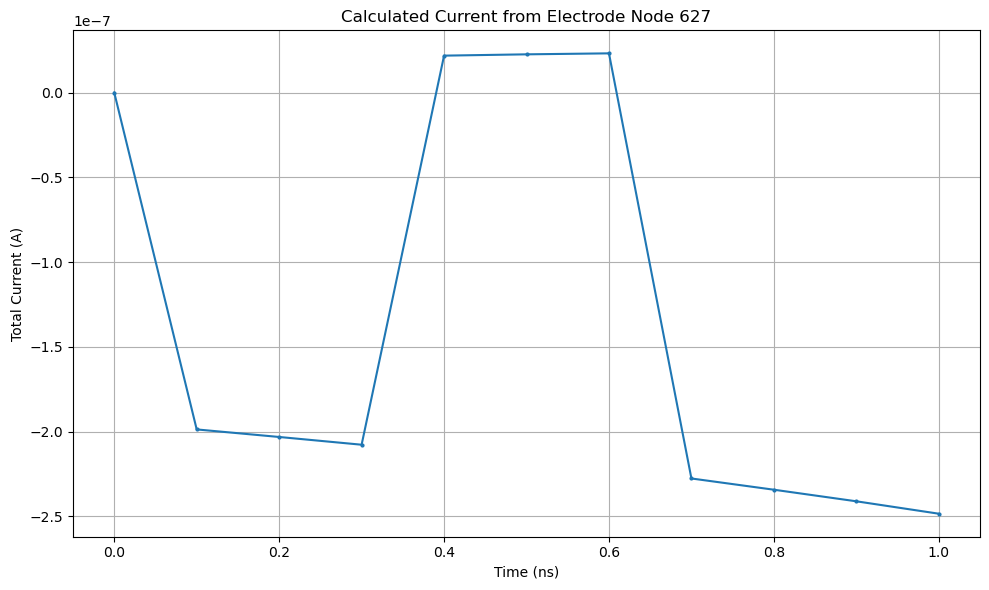


Calculating current for the second measuring electrode...
Loading simulation data...
Initializing 3D mesh...
Calculating current for 11 time steps...


Processing Time Steps: 100%|██████████| 11/11 [00:00<00:00, 1179.32it/s]

Plotting results...


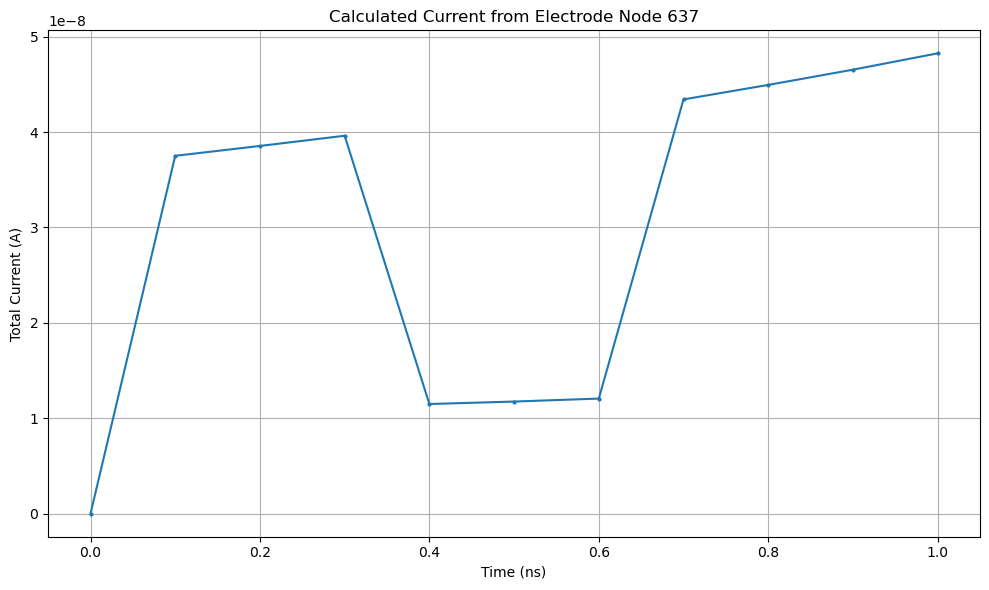

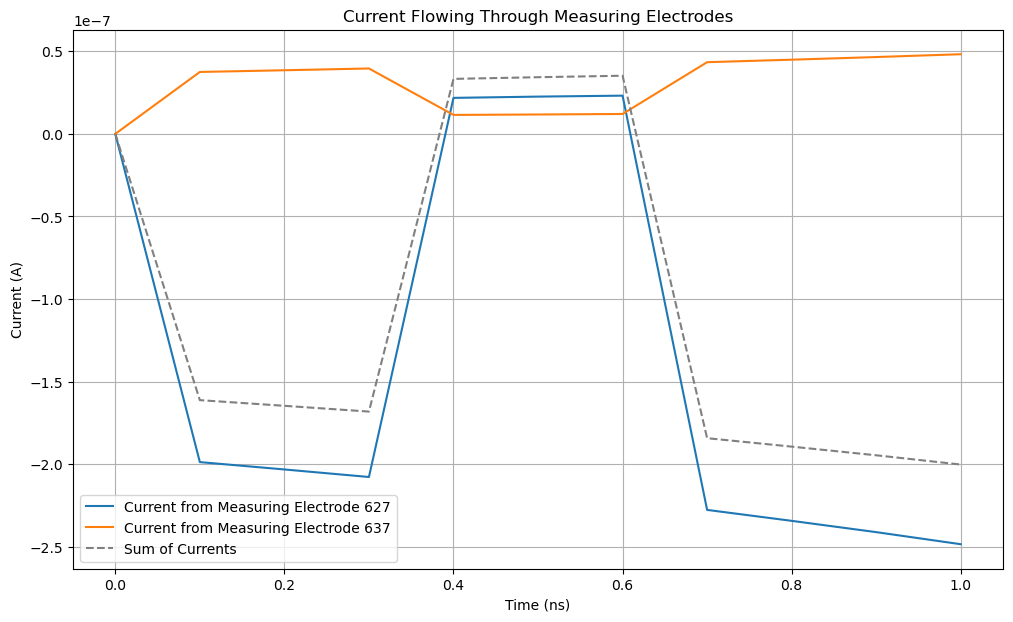

In [25]:
print("\nCalculating current for the first measuring electrode...")
t_sense1, I_sense1 = calculate_electrode_current3d(sensing_electrode1_idx)

print("\nCalculating current for the second measuring electrode...")
t_sense2, I_sense2 = calculate_electrode_current3d(sensing_electrode2_idx)

#t_stim1, I_stim1 = calculate_electrode_current(stimulating_electrode1_idx)
#t_stim2, I_stim2 = calculate_electrode_current(stimulating_electrode2_idx)


# Plotting them together shows the relationship
plt.figure(figsize=(12, 7))
plt.plot(t_sense1 * 1e9, I_sense1, label=f'Current from Measuring Electrode {sensing_electrode1_idx}')
plt.plot(t_sense2 * 1e9, I_sense2, label=f'Current from Measuring Electrode {sensing_electrode2_idx}')
#plt.plot(t_stim1 * 1e9, I_stim1, label=f'Current from Stimulating Electrode {stimulating_electrode1_idx}')
#plt.plot(t_stim2 * 1e9, I_stim2, label=f'Current from Stimulating Electrode {stimulating_electrode2_idx}')
    
    # The sum should be close to zero if they are an isolated pair
plt.plot(t_sense1 * 1e9, I_sense1 + I_sense2 , label='Sum of Currents', linestyle='--', color='gray')
    
plt.title("Current Flowing Through Measuring Electrodes")
plt.xlabel("Time (ns)")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.show()